# Metody uczenia maszynowego 2017 - Podstawowe metody klasyfikacji

<img src="../mum_figures/ml_map.png" width="100%"/>

<h1 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [6]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

In [8]:
from __future__ import print_function
from __future__ import unicode_literals
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing

In [9]:
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [10]:
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples, completeness_contamination

# Zadanie Klasyfikacji

* ewaluacja gęstości prawdopodobieństwa w zadaniu __klastrowania__
  * grupowanie wykorzystujące cechy
  * to klasyfikacja __nienadzorowana__
* niech część __prawdziwych__ etykiet będzie dostępna
  * zadanie klasyfikacji __nadzorowanej__
        
      
## zadanie klasyfikacji    

* __zadanie klasyfikacji__: zbiór uczący 
$$\{(x_k, y_k)\}_{k=1}^N\;\text{gdzie}\;y_k\in\{1,\dots,K\}\;\text{jest indeksem prawdziwej klasy przykładu } x$$
  * zakładamy, że przykład należy __tylko do jednej__ z klas
    * to __klasyfikacja wielo-klasowa__ (ang. _multi-class_)
  * jeśli przykład należy przypisać do __więcej__ niż jednej klasy, to mówimy o klasyfikacji __wielo-etykietowej__ (ang. _multi-label_)
  
* klasyfikator jest funkcją $g$ taką, że __(hiper-)płaszczyzna decyzyjna $f(x)=0$ rozdziela klasy__
  
  
## klasyfikacja a regresja
* regresja zakłada ciągłość gęstości prawdopodobieństwa przykładów w jakiejś podprzestrzeni przykładów
  * w przypadku klasyfikacji nie zawsze można o tym mówić
* regresja wyjaśnienia sposób tworzenia przykładów w przestrzeni wejściowej
  * z tym związane __generatywne__ podejście do klasyfikacji
* klasyfikacja ma za zadanie __podział__ podprzestrzeni przykładów hiperpłaszczynami decyzyjnymi
  * podejście __dyskryminatywne__ klasyfikacji

## Funkcja kosztu (loss)
* najczęstsza zero-jedynkowa (ang. _zero-one loss_) 
$$
L(y,\widehat{y})=\begin{cases}
1\;\;\;\text{jeśli } y\neq\widehat{y}\\
0\;\;\;\text{wpp}
\end{cases}
$$
* stąd __ryzyko__ modelu - __wartość oczekiwana kosztu__ 
$$\mathbf{E}[L(y,\widehat{y})]=p(y\neq\widehat{y})$$
  * w regresji była to zwykle funkcja kwadratowa
  * koszt zero-jedynkowy to __ułamek błednych odpowiedzi__

## Stosunki poprawnych i niepoprawnych odpowiedzi
* problem zwykle polega na wykryciu obiektu danej klasy
* odpowiedzi mogą być różnej postaci
  * true positives
  * false positives
  * true negatives
  * false negatives
  
* __czułość__ (recall, true positive rate, sensitivity, completness) systemu: frakcja rozpoznanych przykładów, które są zgodne z zapytanienm
$$\text{recall}=\frac{\text{true positives}} {\text{true positives}+\text{false negatives}}$$
* __precyzja__ (precision, ) systemu: frakcja przykładów zgodnych z zapytaniem, które zostały rozpoznane
$$\text{precision}=\frac{\text{true positives}} {\text{true positives}+\text{false positives}}$$
* __specificity__ frakcja negatywnych poprawnie rozpoznanych
$$\text{specitivity}=\frac{\text{true negatives}}{\text{true negatives}+\text{false positives}}$$
<img src="../mum_figures/precision_recall.png" width="50%"/> [rysunek za Wikipedia]


* elementy analizy ROC
  * wykres recall (sensitivity) względem (1 - specitivity)
<img src="../mum_figures/ROC_space.png" width="70%"/>
[By ROC_space.png: Indonderivative work: Kai walz (talk) - ROC_space.png, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=8326140]
<img src="../mum_figures/ROC_errtypes.png" width="100%"/>
[By kakau - Selbstgepinselt mit PowerPoint, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=10657501]
  * pozwala łatwo wprowadzić pojęcie kosztu pomyłki
  * system medyczny
    * przewiduje, czy osoba jest chora na chorobę X
    * __false positive__ błędna predykcja, że osoba __jest__ chora
    * __false negative__ błędna predykcja, że osoba __nie jest__ chora
    * błąd typu __false negative__ niesie za sobą znacznie groźniejsze skutki!


* __dokładność__ (accuracy)
$$\text{accuracy}=\frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$
* można połączyć precision i recall jako średnią harmoniczną
$$F_1=2\cdot\frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}}$$
  * $F_1$ ma wiele wad
  * także $F_\beta$, MCC, $\dots$

<img src="../mum_figures/precision_recall.png" width="50%"/> [rysunek za Wikipedia]

## Klasyfikacja generatywna
* estymacja gęstości przykładów z poszczególnych klas w przestrzeni wejściowej
* mając zbiór danych $$\{(x_i, y_i)\}_{i=1}^N,$$ gdzie $x_i$ jest wektorem z $D$-wymiarowej przestrzeni, a $y_i\in\{1,\dots,K\}$

$$p(y_k\mid x_i)=\frac{p(x_i\mid y_k)\,p(y_k)}{\sum_l p(x_i\mid y_l)\,p(y_l)}$$

* klasyfikacja __generatywna__ modeluje gęstość $$p_k(x)=p(x\mid y=y_k)$$
  * niech $\pi_k=p(y=y_k)$
  * $\pi_k$ jest __priorem__ klasy $k$
    * jeśli użyjemy subjektywnego $\pi_k$ to dostaniemy model Bayesowski
    * jeśli estymujemy $\pi_k$ z danych, to model __częstotliwosciowy__ albo __empiryczny Bayesowski__

## Funkcja dyskryminatywna
* $\widehat{y}=f(y\mid x)$ będziemy nazywać funkcją __dyskryminatywną__, dającą najlepszą prawdopodobną klasyfikację $x$
$$\begin{align}
g(x)=f(y\mid x)&=\int yp(y\mid x)dy\\
&=1\cdot p(y=1\mid x)+0\cdot p(y=0\mid x)\\&=p(y=1\mid x)
\end{align}$$

* wykorzystując regułę Bayesa mamy
$$\begin{align}
g(x)&=\frac{p(x_i\mid y_k)\,p(y_k)}{\sum_l p(x_i\mid y_l)\,p(y_l)}\\
&=\frac{p(x\mid y=1)\,p(y=1)}{p(x\mid y=1)\,p(y=1)+p(x\mid y=0)\,p(y=0)}\\
&=\frac{\pi_1 p(x\mid y=1)}{\pi_1 p(x\mid y=1)+\pi_0 p(x\mid y=0)}\\
&=\frac{\pi_1 p_1(x)}{\pi_1 p_1(x)+\pi_0 p_0(x)}
\end{align}$$


# Klasyfikacja Bayesowska

* dla 2 klas mamy __klasyfikator Bayesowski__ zdefiniowany według reguły

$$\begin{align}
\widehat{y}&=\begin{cases}1\hskip{2em}g(x)>1/2\\0\hskip{2em}wpp\end{cases}\\
&=\begin{cases}1\hskip{2em}p(y=1\mid x)>p(y=0\mid x)\\0\hskip{2em}wpp\end{cases}\\
&=\begin{cases}1\hskip{2em}\pi_1p_1(x)>\pi_0p_0(x)\\0\hskip{2em}wpp\end{cases}
\end{align}$$
* dla większej liczby klas __Bayesowska reguła klasyfikacji__

$$\boxed{
\text{Przypisz}\; x\; \text{do klasy}\; y_i=\underset{y_j}{\arg\max}\;\pi_j\,p(x\mid y=y_j)\;\;\;j=1,\dots,K\;
}$$

* __zbiór wartości $x$ takich, że $$\pi_1p_1(x)=\pi_2p_2(x)$$ nazywamy __granicą decyzyjną__

## Minimalizacja błędu klasyfikacji

* niech będzie dany problem 2-klasowy
  * niech obszar $\mathcal{R}_1$ będzie bardziej prawdopodobny dla klasy $y_1$  
  * niech obszar $\mathcal{R}_2$ będzie bardziej prawdopodobny dla klasy $y_2$
  * wtedy prawdopodobieństwo błędu
  $$P_{err}=P(y_2)\int_{\mathcal{R}_1}p(x\mid y_2)\,dx + P(y_1)\int_{\mathcal{R}_2}p(x\mid y_1)\,dx$$
  minimalizuje błąd
    * odsunięcie od optymalnej wartości bayesowskiej (oddzielającej) $\mathcal{R}_1$ od $\mathcal{R}_2$ zwiększa błąd

* klasyfikator Bayesowski jest __wzorcem__: że można podstawić dowolny model za $p_k$ i $\pi_k$
* jest __optymalny__, jeśli za $p_k$ i $\pi_k$ podstawić prawdziwe rozkłady

In [11]:
def plot_bayesian_rule_minimizes():
    fig, ax = plt.subplots(2, 1, figsize=(18, 12))
    left = -10.0; right = 10.0; step = 0.1
    x = np.arange(left, right, step)
    mu = [-3.0, +4.0]
    s = [1.80, 2.26]
    color = ['pink', 'green']
    y = [0, 0]
    for i in [0, 1]:
        y[i] = np.exp(-((x - mu[i]) ** 2) / (2 * s[i] ** 2))
        ax[0].plot(x, y[i])
        ax[0].fill_between(x, 0, y[i], facecolor=color[i], alpha=0.05)
    yy = [min(a, b) for (a, b) in zip(y[0], y[1])]
    eq_pt = 0.1
    xl = np.arange(left, eq_pt + step, step)
    yl = yy[:len(xl)]
    ax[0].fill_between(xl, 0, yl, facecolor=color[1], alpha=0.18)
    xr = np.arange(eq_pt, right, step)
    yr = yy[-len(xr):]
    ax[0].fill_between(xr, 0, yr, facecolor=color[0], alpha=0.18)
    ax[0].axvline(eq_pt, ls='--')
    ax[0].set_ylim([-step / 2, 1.1])

    for i in [0, 1]:
        ax[1].plot(x, y[i])
        ax[1].fill_between(x, 0, y[i], facecolor=color[i], alpha=0.05)
    neq_pt = 0.7
    ax[1].axvline(neq_pt, ls='--')
    xl = np.arange(left, neq_pt + step, step)
    yy = y[1][:len(xl)]
    ax[1].fill_between(xl, 0, yy, facecolor=color[1], alpha=0.18)
    xr = np.arange(neq_pt, right, step)
    yy = y[0][-len(xr):]
    ax[1].fill_between(xr, 0, yy, facecolor=color[0], alpha=0.18)
    ax[1].set_ylim([-step / 2, 1.1])

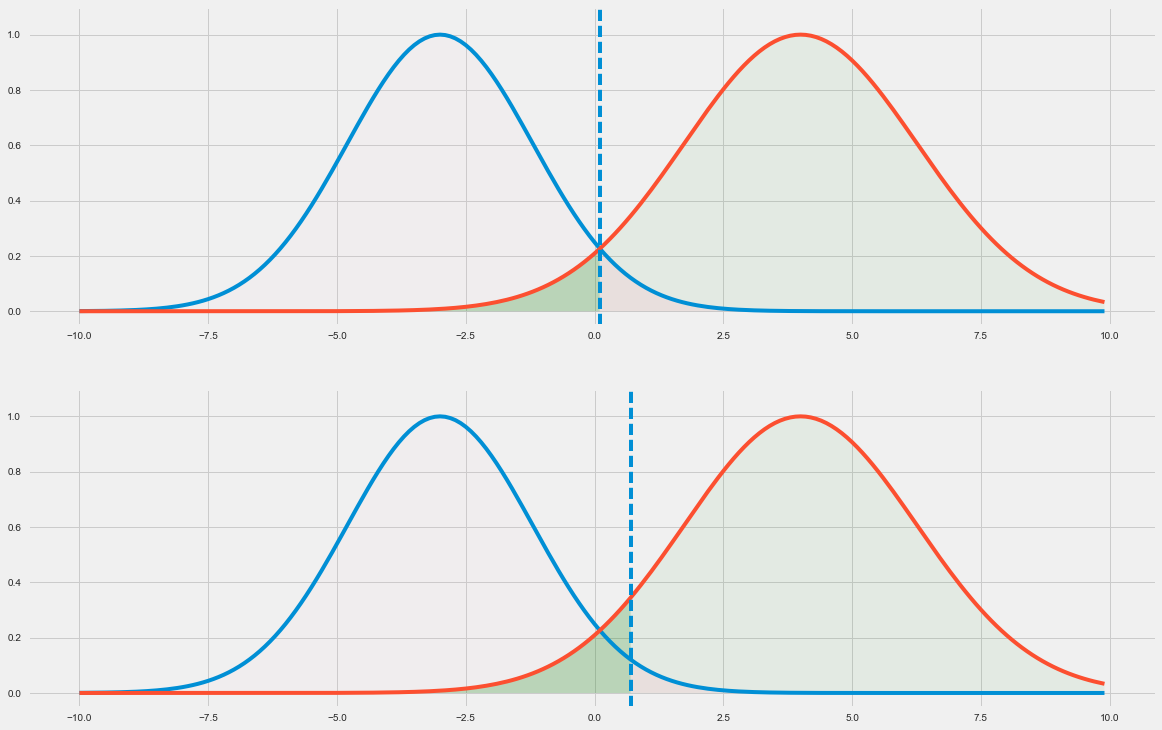

In [12]:
plot_bayesian_rule_minimizes()

## Średni błąd

* nie każdy błąd jest tego samego rodzaju i tej samej wagi
  * w systemach medycznych mamy dwa podstawowe błędy
    * predykcja, że pacjent jest _chory_, podczas gdy w rzeczywistości jest _zdrowy_
    * przeciwnie, predykcja, że jest _zdrowy_ gdy naprawdę jest _chory_
    * drugi błąd ma znacznie wyższy __koszt__
    
    
* __ryzyko__ albo __koszt__ (ang. _loss_) związane z klasą $y_k$ ma postać $$r_k=\sum_{j=1}^K\lambda_{kj}\int_{\mathcal{R}_j}p(x\mid y_j)\,dx$$ gdzie $\lambda_{kj}$ jest wagą niepoprawnej klasyfikacji przykładu z klasy $y_k$ do klasy $y_j$
  
  
* __średnie ryzyko__ 
$$R[]=\sum_kP(y_k)r_k=\sum_j\int_{\mathcal{R}_j}\left(\sum_k\lambda_{kj}P(y_k)p(x\mid y_k)\right)\,dx$$
  
  
* reguła wyboru dla binarnej klasyfikacji będzie miała postać
$$\begin{align}
\text{przypisz}\; x\; \text{do}\; y_1\; \text{jeśli}\; &\lambda_{12}P(y_1\mid x) > \lambda_{21}P(y_2\mid x)\\
\text{przypisz}\; x\; \text{do}\; y_2\; \text{jeśli}\; &\lambda_{12}P(y_1\mid x) < \lambda_{21}P(y_2|x)\\
\end{align}$$
  
  
* macierz $L=[\lambda_{ij}]$ nazywamy __macierzą kosztów__ (ang. _loss matrix)
  
  
* bayesowska reguła jest ostrym podziałem
  * często wartości _a posteriori_ są bardzo podobne
  * sensowne może być wtedy __nie dokonanie__ żadnego wyboru
  * wiąże się to z wybraniem innych wartości progowych osobnych dla każdej klasy

## Naiwny klasyfikator Bayesowski

* dla dobrej estymacji gęstościpotrzeba dużej liczby przykładów
  * coraz bardziej prawdziwe wraz ze zwiększaniem się wymiarowości problemu
  
  
  ----
  
  > Niech będzie problem ceny metra kwadratowego (jako problemu klasyfikacji) w domu zależny od dwóch parametrów  $x_1$: powierzchni oraz $x_2$: roku budowy
  
  > Wtedy
  $$\begin{align}
P(y_k\mid x_1,x_2)&=\frac{P(x_1,x_2\mid y_k)P(y_k)}{P(x_1,x_2)}\propto P(x_1,x_2\mid y_k)P(y_k)\\
&\propto{}P(x_1\mid y_k)P(x_2\mid y_k)P(y_k)=\frac{P(y_k\mid x_1)P(x_1)}{P(y_k)}\frac{P(y_k\mid x_2)P(x_2)}{P(y_k)}P(y_k)\\
&\propto\frac{P(y_k\mid x_1)P(y_k\mid x_2)P(x_1)P(x_2)}{P(y_k)}\\
&\propto\frac{P(y_k\mid x_1)P(y_k\mid x_2)}{P(y_k)}
  \end{align}$$
  
  ---
  
  
* __naiwny klasyfikator bayesowski__ robi  (naiwne) założenie, że wszystkie atrybuty (ang. _features_) wejściowe są __statystycznie niezależne__
  * wtedy $$p(x\mid y_k)=\prod_{i=1}^l p(x_i\mid y_k)\;\;\;k=1,\dots,K$$
  * wymaga znalezienia średnich i wariancji dla każdego wymiaru, razem $2l$ parametrów
  * wtedy używając reguły Bayesa mamy
$$\begin{align}
p(y_k\mid x_1,\dots,x_D)
&=\frac{\prod_{i=1}^D p(x_i\mid y_k)\,p(y_k)}{\sum_j\prod_{i=1}^D p(x_i\mid  y_j)\,p_(y_j)}\\
&=\frac{\prod_{i=1}^Dp_k(x_i)\pi_k}{\sum_j\prod_{i=1}^Dp_j(x_i)\pi_j}
\end{align}
$$

* __przekleństwo wymiarowości__ mówi, że wraz ze wzrostem wymiaru trzeba więcej danych, generalnie $N^l$ danych jest potrzebnych w $l$ wymiarach
  * gdy $x_i$ są dyskretne, to obliczenie $p_k(x_i)$ jest prostym ułamkiem liczby przykladów z klasy $y=y_k$ z wartością $x_i$ 
  * możemy mieć pecha i dostać $p_k(x_i)=0$
    * wtedy posterior będzie $p(y_k\mid \{x_i\})=0\,/\,0$!
  * __wygładzanie Laplace'a__: dodać małe $\epsilon$ do wszystkich $p_k(x_i)$
  * wygląda jak trik
  * jest równoważne wrpowadzeniu pewnego prioru

### Gaussowski naiwny klasyfikator Bayesa
* każda ze współrzędnych jest modelowana jako jednowymiarowy rozkład normalny
  * zaklada, że wielowymiarowy rozkład normalny może być modelowany rozkładami jedno-wymiarowymi __równoległymi do osi__

### Gausowski klasyfikator Bayesa
* jeśli opuścimy założenie o warunkowej niezależności współrzędnych, to otrzymamy gausowski klasyfikator Bayesa
  * obliczenie $p(x\mid y_k)=p_k(x)$ staje się bardziej złożone
  $$p_k(x)=\frac{1}{|\Sigma_k|^{1/2}(2\pi)^{D/2}} \exp\left(-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)\right),$$
  gdzie $\Sigma_k$ jest macierzą kowariancji
  * algorytm jest zwykle znacznie bardziej złożony obliczeniowo

In [13]:
from sklearn.datasets import make_circles, make_classification, make_hastie_10_2, make_moons
from sklearn.datasets import make_multilabel_classification, make_blobs
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from matplotlib.colors import ListedColormap

In [14]:
def simple_classification(data='circles', classifier='Gaussian', centers=2,
                          n_samples=200, noise = 0.1):
    if data == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise)
        reds, blues = (y == 0, y == 1)
    elif data == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
        reds, blues = (y == 0, y == 1)    
    elif data == 'hastie':
        X, y = make_hastie_10_2(n_samples=n_samples)
        reds, blues = (y == -1, y == +1)    
    elif data == 'classification':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, n_repeated=0,
                                  n_clusters_per_class=1)
        reds, blues = (y == 0, y == 1)
    elif data == 'blobs':
        X, y = make_blobs(n_samples=n_samples, n_features=2, centers=centers, cluster_std=noise)
        reds, blues = (y == 0, y == 1)
    else:
        print('simple_classification: undefined data set: {}'.format(data))
     
    h = 0.01
    margin = 0.5
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    fig, ax = plt.subplots(figsize=(16, 8))
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    ax.plot(X[reds, 0], X[reds, 1], 'r*', lw=8, marker='o')
    ax.plot(X[blues, 0], X[blues, 1], 'b*', marker='o')
    
    if classifier == "Gaussian":
        clf = GaussianNB()
    elif classifier == "Bernoulli":
        clf = BernoulliNB()
    elif classifier == "LDA":
        clf = LDA()
    elif classifier == "QDA":
        clf = QDA()
    else:
        raise ValueError("Classifier {} not defined".format(classifier))
    clf.fit(X, y)
    score = clf.score(X, y)

    if hasattr(clf, 'decision_function'):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha = 0.25)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
   

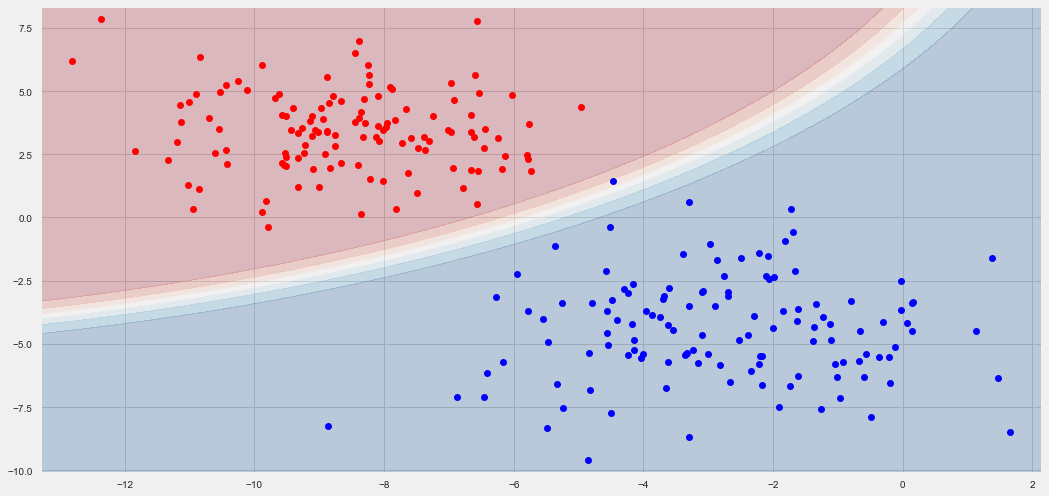

In [19]:
simple_classification(data='blobs', centers=2, classifier="Gaussian", 
                      n_samples=250, noise=1.75)

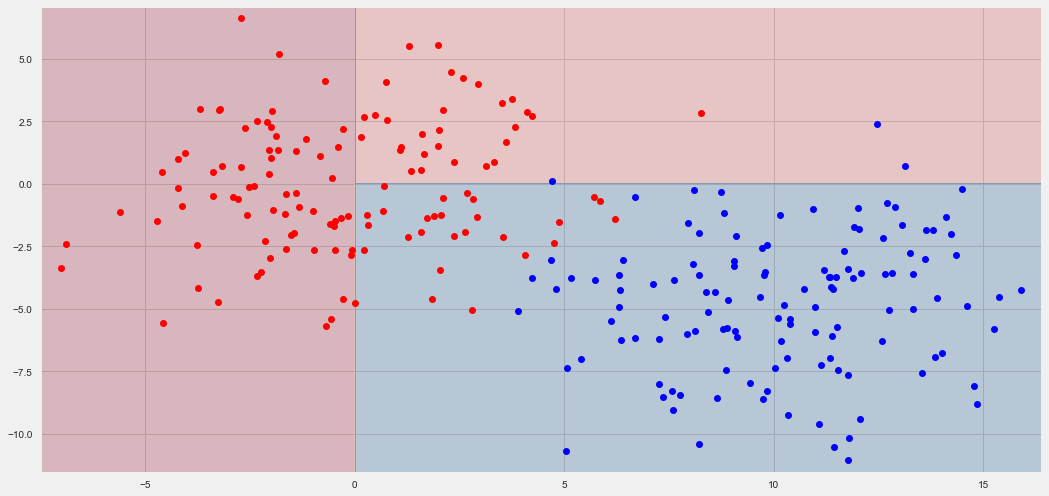

In [20]:
simple_classification(data='blobs', classifier="Bernoulli", n_samples=250, 
                      noise=2.75)

## Linear Discriminant Analysis
* załada, że wszystkie klasy mają identyczne macierze kowariancji
* zakłada __gausowskie__ rozkłady danych w klasach
  * granice w LDA są __liniowe__ i wypadają tam, gdzie prawdopodobieństwa klas są równe
* QDA zakłada także gausowskie rozkłady
  * algorytm estymuje macierze kowariancji a granice między klasami są kwadratowe
    * estymacja macierzy kowariancji z danych jest ograniczona

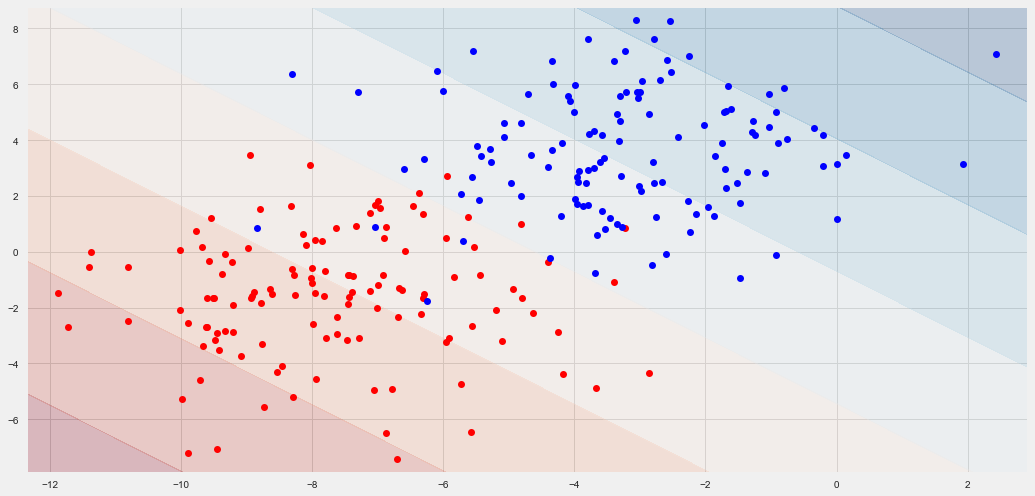

In [30]:
simple_classification(data='blobs', classifier="LDA", n_samples=250, noise=2.0)

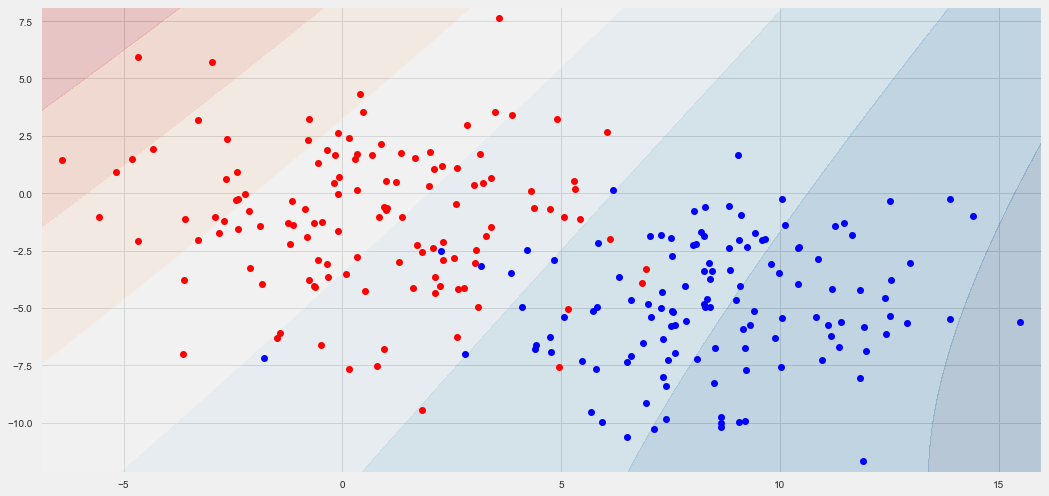

In [37]:
simple_classification(data='blobs', classifier="QDA", n_samples=250, noise=2.75)

In [38]:
def simple_lda_qda(mode='linear', n_samples=100, centers=2, priors=[1, 1], odds='odds'):
    if len(priors) != centers:
        return 'Number of centers and length of priors differ!'
    priors = np.array(priors) / float(np.sum(priors))
    X, y = make_blobs(n_samples=n_samples, centers=centers)
    if mode == 'linear':
        cls = LinearDiscriminantAnalysis(priors=priors)
    elif mode == 'quadratic':
        cls = QuadraticDiscriminantAnalysis(priors=priors)
    cls.fit(X, y)
    
    fig_lines = (centers + 2) / 2
    fig, ax = plt.subplots(fig_lines, 2, figsize=(18, fig_lines * 8))

    h=0.025
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax[0, 0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    ax[0, 0].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax[0, 0].set_xlim(xx.min(), xx.max())
    ax[0, 0].set_ylim(yy.min(), yy.max())
    ax[0, 0].set_xticks(())
    ax[0, 0].set_yticks(())
    
    # odds lub log-odds dla poszczegolnych klas
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    for n in range(centers):
        if odds == 'odds':
            Z = cls.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        elif odds == 'log':
            Z = cls.predict_log_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        Z = Z.reshape(xx.shape)
        row = (n + 1) / 2; col = (n + 1) % 2
        ax[row, col].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

        ax[row, col].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', 
                             cmap=plt.cm.Paired)
        ax[row, col].set_xlim(xx.min(), xx.max())
        ax[row, col].set_ylim(yy.min(), yy.max())
        ax[row, col].set_xticks(())
        ax[row, col].set_yticks(())
    
    plt.tight_layout()

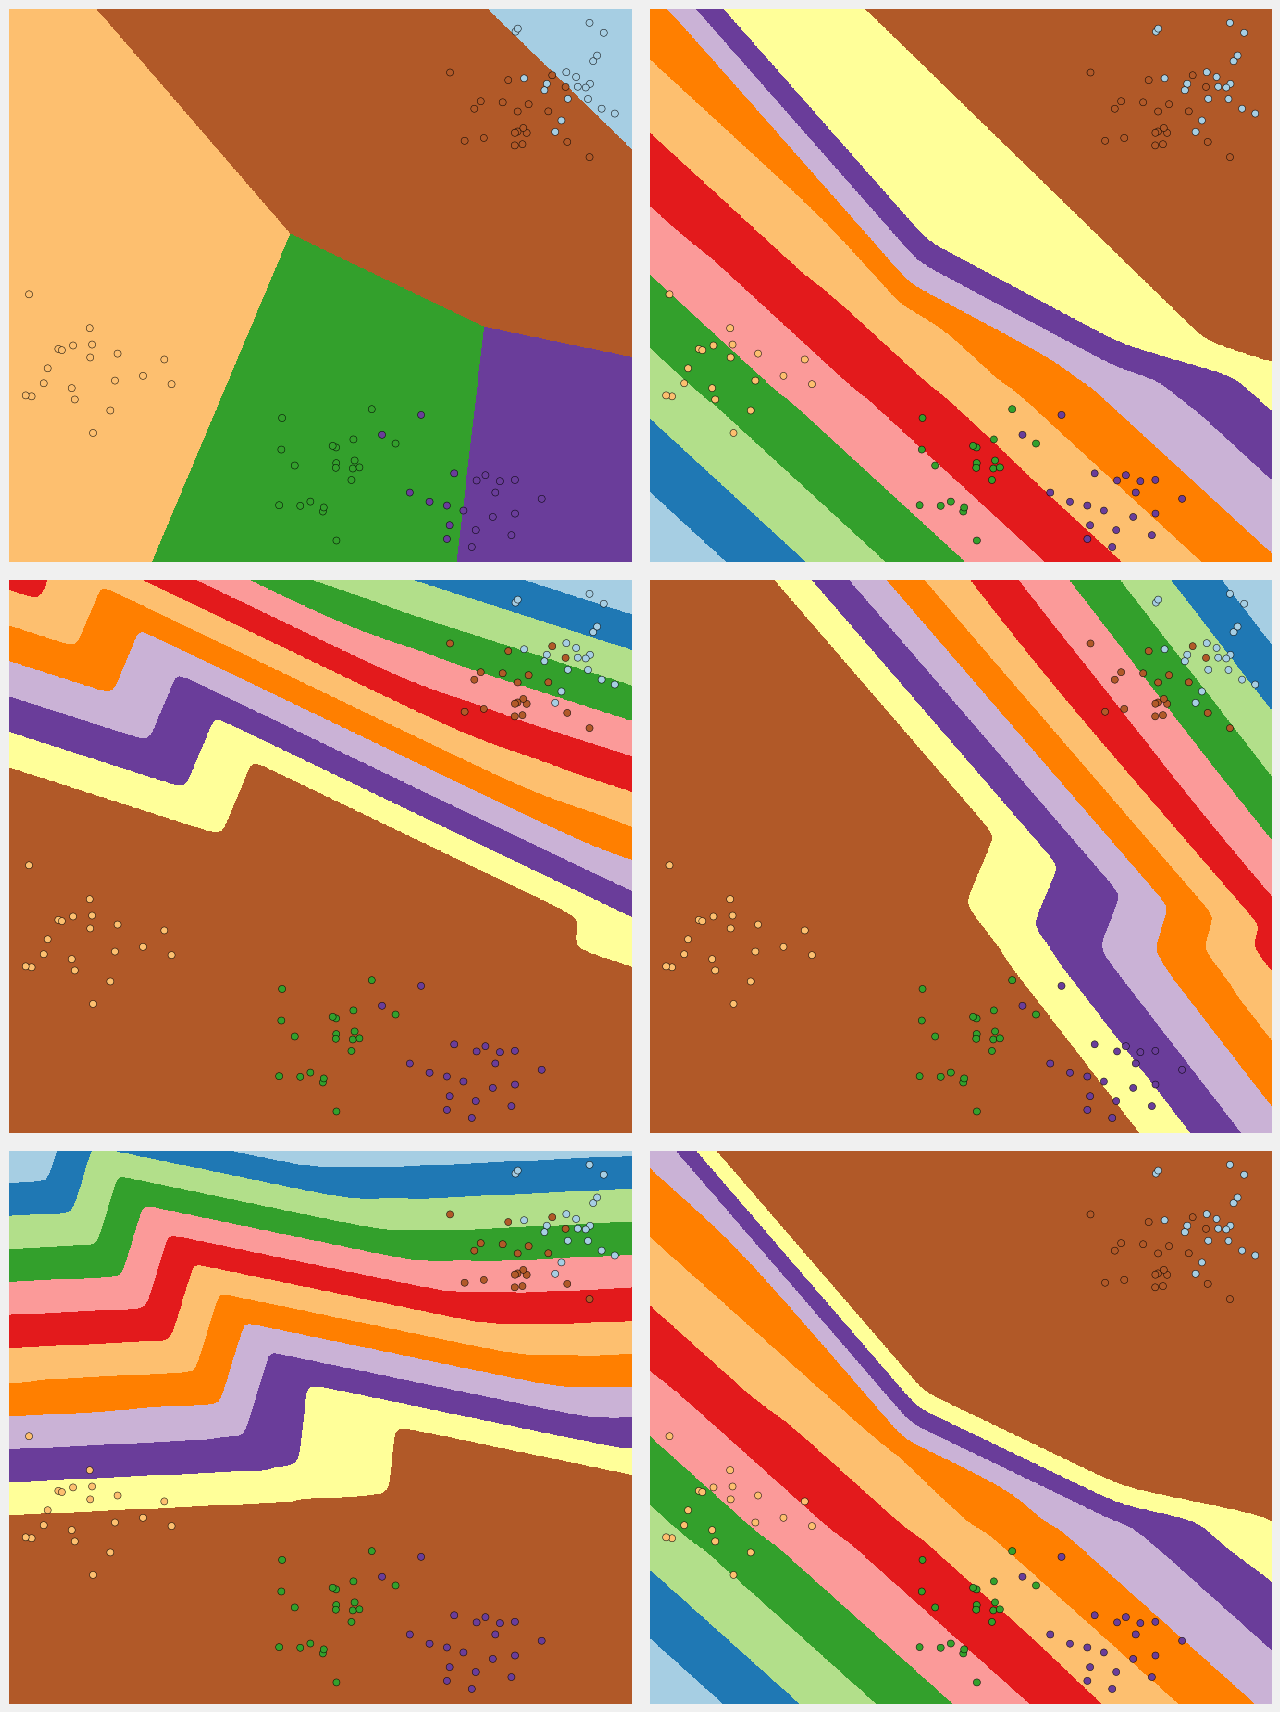

In [42]:
priors = [1, 1, 2, 0.001, 5]
simple_lda_qda(mode='linear', odds='log', centers=len(priors), priors=priors)

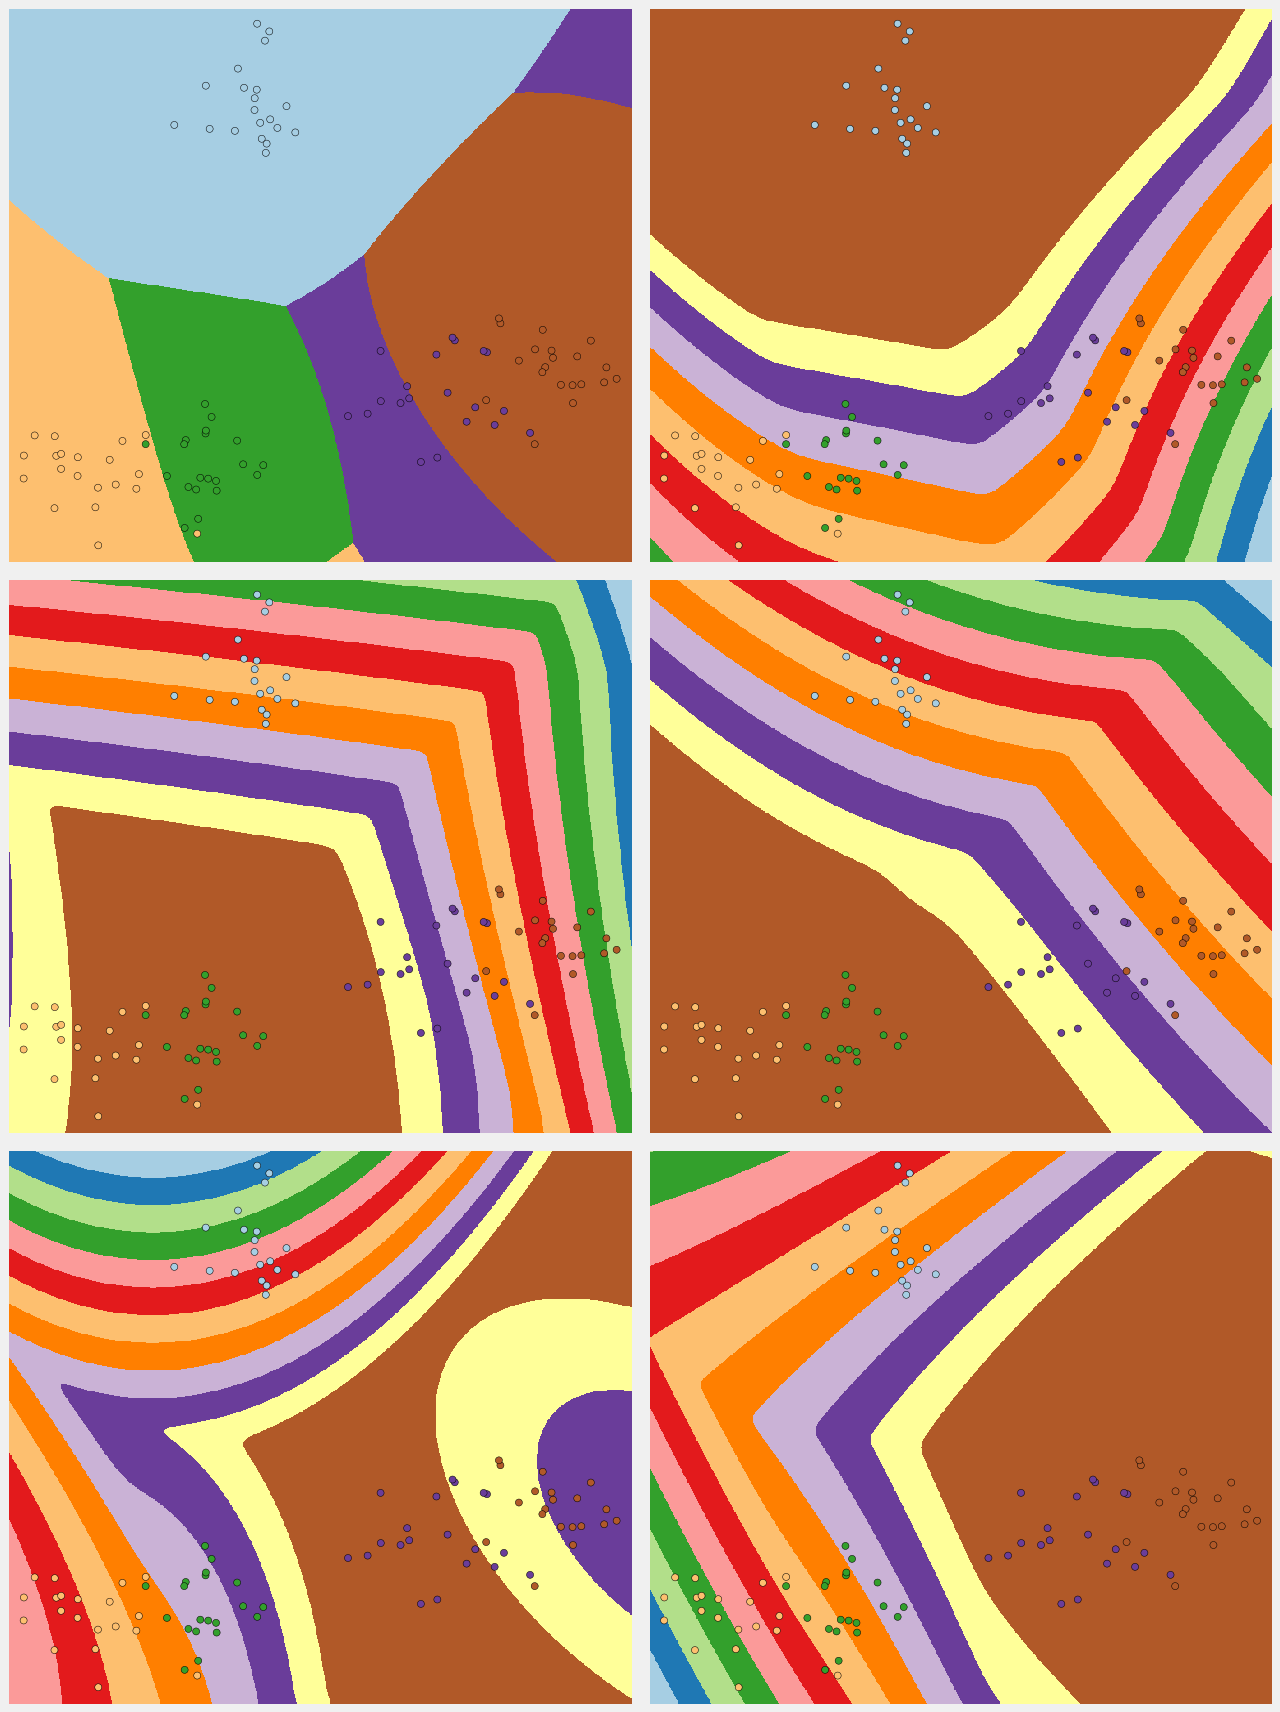

In [43]:
priors = [1, 1, 2, 0.001, 5]
simple_lda_qda(mode='quadratic', odds='log', centers=len(priors), priors=priors)

## Fishers Linear Discriminant
* wszystkie priory są z założenia równe
* macierze kowariancji nie muszą być równe
  * to powoduje próbę rzutowania problemu do jednego wymiaru
  * granica decyzyjna jest wyszukiwana na tej linii

In [44]:
def plot_two_blobs():
    def rotate_vector(v, angle, anchor):
        """Rotate a vector `v` by the given angle, relative to the anchor point."""
        x, y = v

        x = x - anchor[0]
        y = y - anchor[1]

        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)

        nx = x*cos_theta - y*sin_theta
        ny = x*sin_theta + y*cos_theta

        nx = nx + anchor[0]
        ny = ny + anchor[1]
        return [nx, ny]
    
    fig, ax = plt.subplots(1, 2, figsize=(22, 11))
    X, y = make_blobs(centers=2)
    #y = [min(x, 1) for x in z]
    ax[0].scatter(X[:, 0], X[:, 1], c=y+2)
    ind_0 = y == 0
    ind_1 = y == 1
    mu_0 = np.mean(X[ind_0, :], 0)
    ax[0].plot(mu_0[0], mu_0[1], 'b*', markersize=10)
    mu_1 = np.mean(X[ind_1, :], 0)
    ax[0].plot(mu_1[0], mu_1[1], 'r*', ms=10)

    x_range = np.arange(ax[0].get_xlim()[0], ax[0].get_xlim()[1], 0.05)
    slope = (mu_1[1] - mu_0[1]) / (mu_1[0] - mu_0[0])
    intercept = mu_1[1] - slope * mu_1[0]
    ax[0].plot(x_range, x_range * slope + intercept, 'k')
    d_0 = X[ind_0, 0]
    d_1 = X[ind_1, 0]
    dens_0 = gaussian_kde(d_0)
    dens_1 = gaussian_kde(d_1)
    dens_0.covariance_factor = lambda : 0.25
    dens_0._compute_covariance()
    dens_1.covariance_factor = lambda : 0.25
    dens_1._compute_covariance()
    xs = np.linspace(min(X[:, 0]), max(X[:, 0]), 200)
    
    ax_t = ax[0].twinx()
    ax_t.plot(xs, dens_0(xs), c='b')
    ax_t.plot(xs, dens_1(xs), c='r')


    # rotate data and compute density plot
    center_x = (mu_0[0] + mu_1[0]) / 2
    center_y = (mu_0[1] + mu_1[1]) / 2
    
    # line tangent to line joining centers -- simplest decision boundary
    # intercept_tangent = center_y + slope * center_x
    # intercept_tangent = center_y + center_x / slope
    intercept_tangent = center_x / slope + center_y
    ax[0].plot(x_range, -(1. / slope) * x_range + intercept_tangent, 'k--')
    center = (center_x, center_y)
    ax[0].plot(center_x, center_y, 'k+', ms=12)
    #ax[1].plot(center_x, center_y, 'k+', ms=12)
    XR = np.zeros(X.shape)
    angle = -np.arctan(slope)
    for i in range(X.shape[0]):
        XR[i, :] = rotate_vector(X[i, :], angle, center)
    yr = y + 2
    new_center = rotate_vector(center, angle, center)
    ax[1].plot(new_center[0], new_center[1], 'k+', ms=12)
    ax[1].scatter(XR[:, 0], XR[:, 1], c=yr, marker='x')

    d_0 = XR[ind_0, 0]
    d_1 = XR[ind_1, 0]
    dens_0 = gaussian_kde(d_0)
    dens_1 = gaussian_kde(d_1)
    dens_0.covariance_factor = lambda : 0.25
    dens_0._compute_covariance()
    dens_1.covariance_factor = lambda : 0.25
    dens_1._compute_covariance()
    min_val = min(min(X[:, 0]), min(XR[:, 0]), min(X[:, 1]), min(XR[:, 1])) - 0.5
    max_val = max(max(X[:, 0]), max(XR[:, 0]), max(X[:, 1]), max(XR[:, 1])) + 0.5
    xs = np.linspace(min_val, max_val, 200)
    
    ax_twin = ax[1].twinx()
    ax_twin.plot(xs, dens_0(xs), c='b')
    ax_twin.plot(xs, dens_1(xs), c='r')


    ax[0].set_xlim(min_val, max_val)
    ax[0].set_ylim(min_val, max_val)
    ax[1].set_xlim(min_val, max_val)
    ax[1].set_ylim(min_val, max_val)
    
    plt.tight_layout()

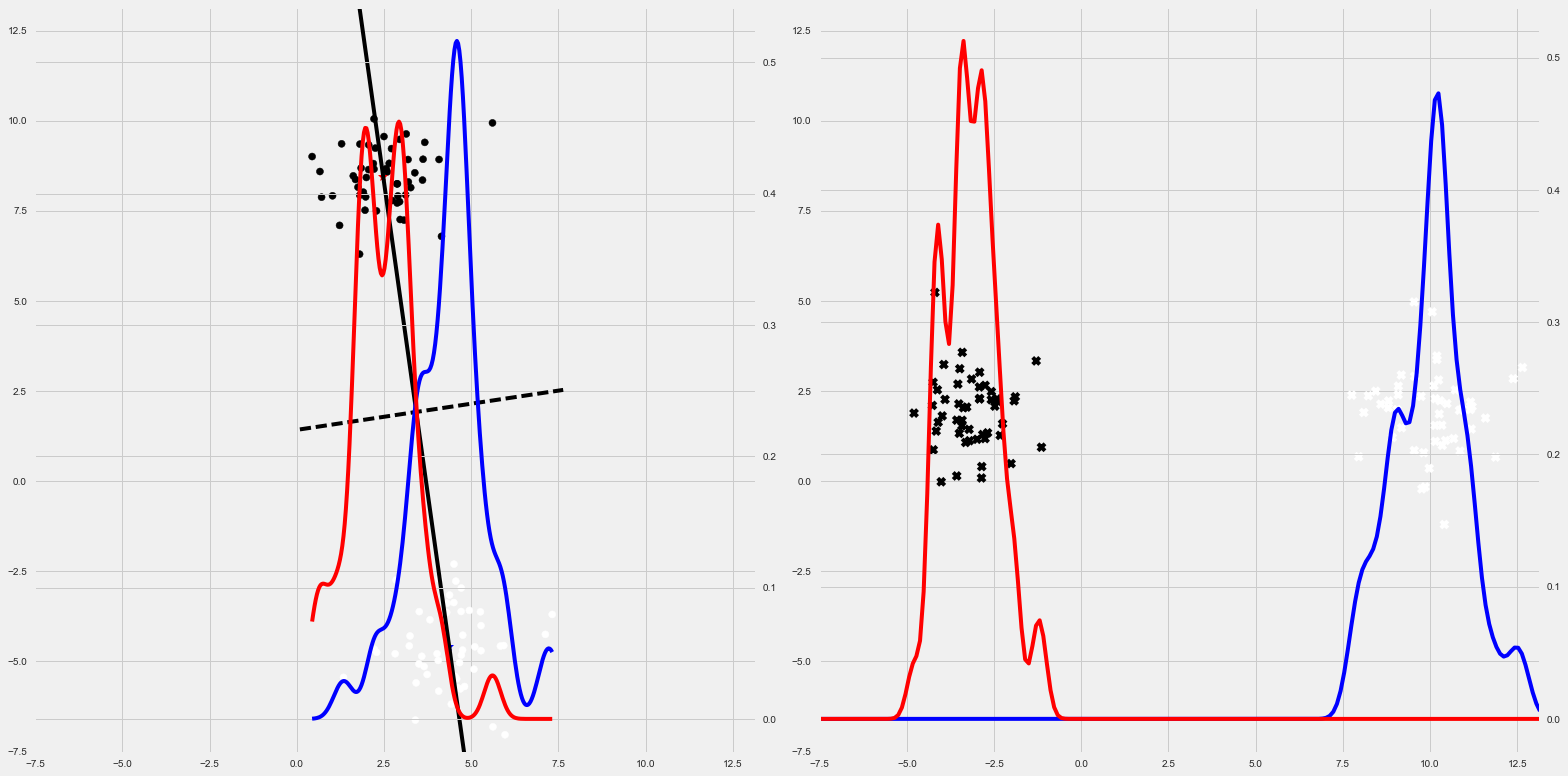

In [47]:
plot_two_blobs()

# Metoda najbliższych sąsiadów

* intuicyjne: klasyfikuj $x$ tak, jak najbliższy z przykladów
* metoda k-nearest neighbours NN jest metodą __bezparametryczną__
  * nie zakłada nic o rozkładach gęstości
  * zbiór przykładów $\{(x_n, y_n), n=1,\dots,N\}$
  * rozszerzenie do $k$ sąsiadów
    * opcja zwykłego głosowania wiekszościowego
    * opcja biorąca pod uwagę odległość do każdego z sąsiadów
      * wagi bliższych sąsiadów są wyższe
    * zwiększanie $k$
      * zmniejsza wariancję błędu
      * ale zwiększa bias
  * $k$ nie powinno być wielokrotnością liczby klas $K$ (dla uniknięcia remisów)
  
  
* k-NN __nie buduje__ statystycznego modelu danych 
  * nie aproksymuje rozkładu $P(y_k|x)$
  * to jest metoda __pamięciowa__
    * zyskuje gdy jest dużo przykładów
      * wtedy staje się czasochłonna
    * granice decyzyjne są bardzo nieregularne
  
  
* błąd k-NN zbliża się do błędu Bayesowskiego jeśli
  * $N\longrightarrow\infty$
  * $k\longrightarrow\infty$
  * $k/N\longrightarrow0$ 
* jeśli $N$ jest wysokie i przestrzeń jest _gęsto_ i _równomiernie_ pokryta danymi, to __zakładając ciągłość__ obliczone wartości prawdopodobieństwa klas będą zbliżać się do prawdziwego $P(y_k|x)$
    

* wadą k-NN jest konieczność obliczenia odległości od wszystkich danych dla każdego $x$
  * istnieją oczywiście usprawnienia wyszukiwania
  * problemem są wymagania pamięciowe k-NN
    * model musi w zasadzie pamiętać wszystkie przykłady
    * są pewne usprawnienia

In [48]:
def k_NN(n_neighbors = 15, n_samples=100, centers=3, cluster_std=2.0):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std)
    h = .02  # step size in the mesh
    fig, ax = plt.subplots(1, 2, figsize=(28, 14))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#AFAFAF',
                                 '#FFFAAA', '#FFF000', '#000FFF', '#FFAAFA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#FAFAFA',
                                '#AAAFFF', '#000FFF', '#FFF000', '#AAFFAF'])

    for k, weights in enumerate(['uniform', 'distance']):
        # we create an instance of Neighbours Classifier and fit the data.
        clf = KNeighborsClassifier(n_neighbors, weights=weights, n_jobs=-1)
        clf.fit(X, y)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        Z = Z.reshape(xx.shape)
        ax[k].pcolormesh(xx, yy, Z, cmap=cmap_light)

        ax[k].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
        ax[k].set_xlim(xx.min(), xx.max())
        ax[k].set_ylim(yy.min(), yy.max())
        ax[k].set_title("{}-NN, weights = '{}'".format(n_neighbors, weights))

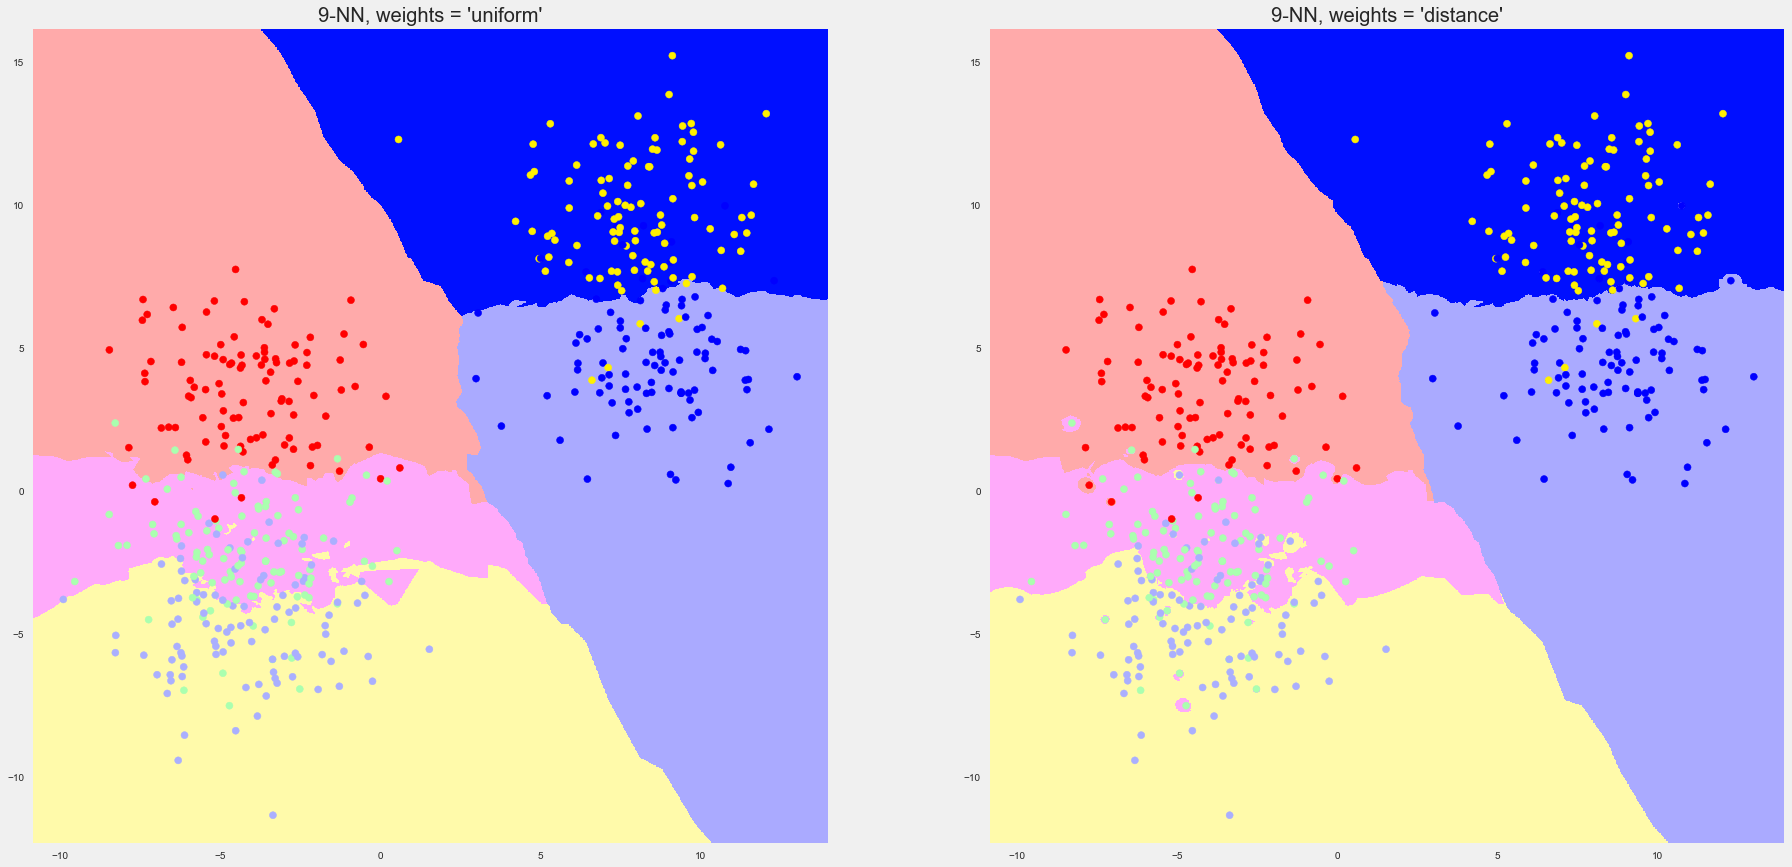

In [49]:
k_NN(n_neighbors=9, n_samples=500, centers=5)

In [50]:
def k_NN_cv_score(centers=3, n_samples=200, max_neighbours=20):
    X, y = make_blobs(n_samples=200, centers=centers, cluster_std=2.0)
    fig, ax = plt.subplots(figsize=(18, 16))
    cv_no = 10
    
    for k, weights in enumerate(['uniform', 'distance']):
        scores = np.zeros((max_neighbours, 2))
        n_range = range(1, max_neighbours)
        for neigh in n_range:
            clf = KNeighborsClassifier(neigh, weights=weights)
            sc = cross_val_score(clf, X, y, cv=cv_no, n_jobs=-1)
            scores[neigh, :] = [np.mean(sc), np.var(sc)]
        ax.errorbar(n_range, scores[1:, 0], scores[1:, 1], label=weights)
        best_ind = np.argmax(scores[:, 0])
        print('Best for {} k-NN: {} neighbours, {}+-{}'.format(weights, best_ind, 
                                                             scores[best_ind, 0], 
                                                            scores[best_ind, 1]))
    ax.set_xlabel('Liczba uzytych sasiadow', fontsize=10)
    ax.set_ylabel("Poprawnosc klasyfikacji", fontsize=12)
    ax.grid()
    ax.legend(loc=0)

Best for uniform k-NN: 13 neighbours, 0.73+-0.0106
Best for distance k-NN: 13 neighbours, 0.705+-0.009225


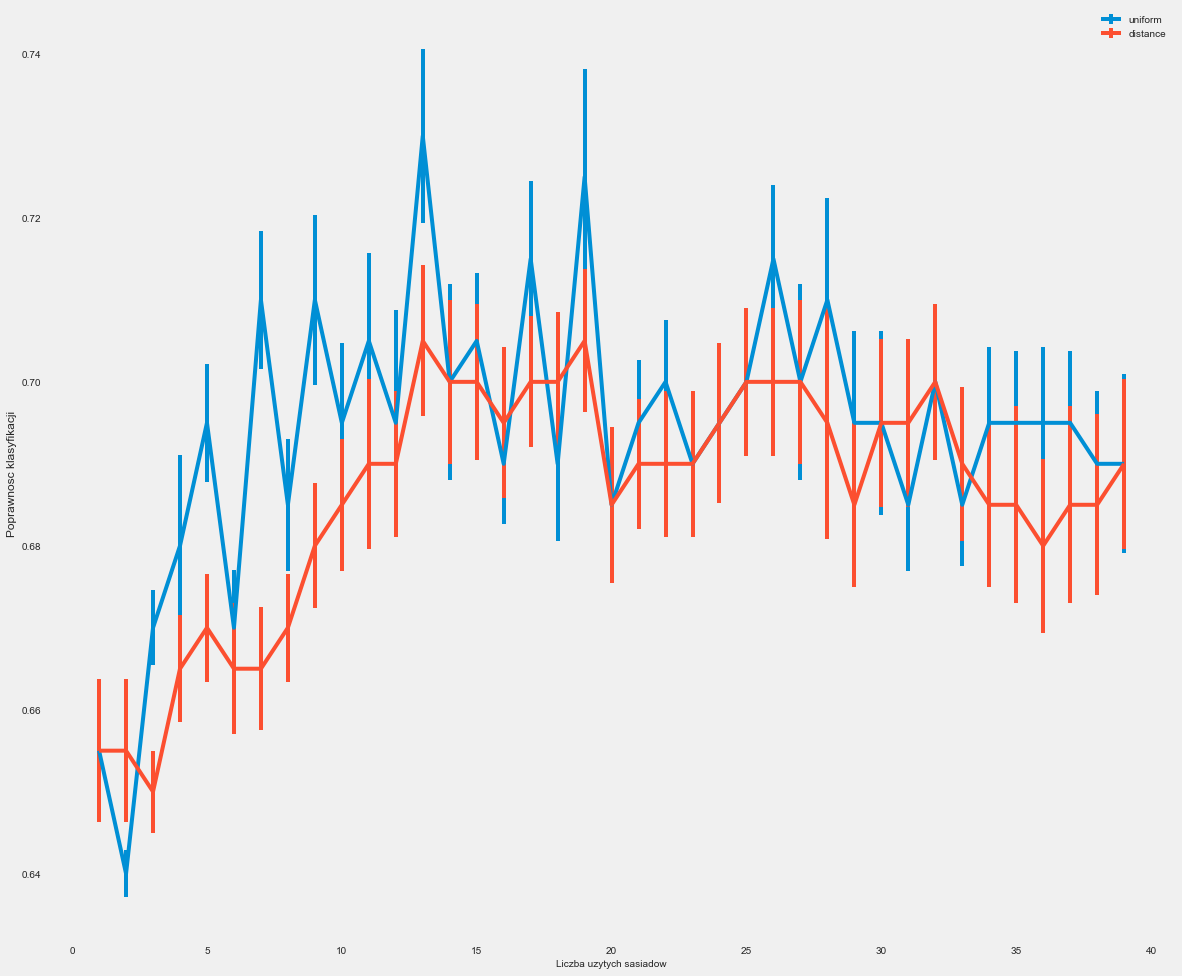

In [51]:
k_NN_cv_score(centers=5, n_samples=500, max_neighbours=40)

### Wykorzystywane miary odległości
* najczęściej wykorzystywana miara euklidesowa
  * to zależy naturalnie od konkretnego problemu i typu danych
  * niewygodne gdy atrybuty różnych typów
    * przeskalowanie jednego zmienia całkowicie wynik
  * typowe miary dla przestrzeni w $\mathbb{R}^n$
    * __euklidesowa__ $\sqrt{(\sum_i((x_i-y_i)^2))}$
    * __manhattan__ $\sum_i |x_i-y_i|$
    * __minkowskiego__ $\sum_i(|x_i-y_i|^p)^{1/p}$
    * __chebyshewa__ $\sum_i(\max(|x_i-y_i|))$
    * __Mahalanobis__ $\sqrt{(x-y)^T\Sigma_{-1}(x-y)}$
  * typowe dla boolowskich wartości
    * __Jaccarda__ (__Tanimoto__) $\frac{x\cap y}{x\cup y}$
    * __dice__, __Kulcinski__, etc.
  * dla atrybutów calkowitych
    * __Hamminga__ $\left[(sign(x-y)+1)/2\right]/\left[\sum (sign(x)+1)/2 + \sum(sign(y) + 1)/2\right]$

* ważne cechy
  * normalizować atrybuty do $[0, 1]$
  * ważyć istotność atrybutóœ przez walidację krzyżową
  * wykorzystywać __niezmienniczość__ problemu, np. w rozpoznawaniu cyfr
    * niezmienniczość ze względu na nieduże rotacje
    * inaczej mierzona odległość _styczna_
    * wyniki klasyfikacji dla problemu rozpoznawania kodów pocztowych na kopertach (za Hastie et al.)
      
      
|||
|-|-|
|Model|błąd|
|warstwowa sieć neuronowa|$0.049$|
|1-NN, odległość Euklidesowa|$0.055$|
|1-NN, odległość styczna|$0.026$|
||||
      
      
* w wysokich wymiarach przestrzeni danych pojawiają się problemy
  * przykłady są w dużej od siebie odległości
    * dla utrzymania stałej gęstości liczba przykładów powinna być proporcjonalna do $N^D$, gdzie $D$ jest wymiarem
  * najbliższy sąsiad może znajdować się w zupełnie innym miejscu przestrzeni
  * nie ma ciągłosci pokrycia
    * możliwe metody hierarchicznego k-NN

# Modele dyskryminacyjne klasyfikacji

* metody K sąsiadów odchodzą od przybliżania rozkładów
* metody __dyskryminacyjne__ bezpośrednio modelują funkcję __granicy decyzyjnej__, np. dla dwóch klas

$$\begin{align}
\widehat{y}&=\begin{cases}1\hskip{2em}g(x)>1/2\\0\hskip{2em}wpp\end{cases}
\end{align}$$


* zbiory danych takie, że klasy __można rozdzielić__ przy pomocy granic decyzyjnych nazwywamy __liniowo separowalnymi__
* dla klasyfikacji istotny będzie sposób kodowania zmiennej zależnej $y$
  * dla problemów binarnych wystarczy $y$ skalarne
  * dla wielu klas popularna jest reprezentacja typu __1-of-K__

## Liniowe funkcje dyskryminacyjne

* najprostszy model 
$$\boxed{\begin{align}
\widehat y(x)&=\theta^Tx+\theta_0\\
y&=y_1\;\;\text{jeśli }\;\widehat y(x)\geq0\\
y&=y_2\;\;\text{jeśli }\;\widehat y(x)<0
\end{align}\;
}$$
  * hiperpłaszczyzna wyznaczona przez $y(x)=0$ jest __przesunięta__ względem początku układu współrzędnych o $\displaystyle -\frac{\theta_0}{\|\theta\|}$
  * $x$ jest odległy od hiperpłaszczyzny o $\displaystyle \frac{y(x)}{\|\theta\|}$
  <img src="../mum_figures/discriminative.png" width=70%/> [rysunek za Bishop]
  
  
* podobnie jak w przypadku regresji wygodnie jest rozszerzyć $\theta=[1\; \theta]$ i zapisywać $$y(x)=\theta^Tx$$

## Problemy wieloklasowe
<!--[potrzebny rysunek]-->
* rozwiązując zadanie dla wielu klas można użyć jednego z wielu modeli
  * __jeden-przeciwko-reszcie__ (ang. __one-versus-the-rest__) rozwiązując $K-1$ problemów przypisania do klasy $c_k$ względem przypadków z innych klas
    * obszar na który nie wskazuje żadna ze zdefiowanych funkcji jest przypisywany do pozostałej klasy
    * może często prowadzić do niejednoznacznego przypisania
  * __jeden przeciwko_każdemu__ (ang. _one-versus-one_) daje $K(K-1)$ problemów dla każdej pary klas
    * przypisanie każdej klasy przez głosowanie większościowe
    * prowadzi do bardzo wielu zadań, także niejednoznacznych podziałów
  * __error correcting output code ECOC__
    * $L<K$ klasyfikatorów
    * każdy klasyfikator typu __kilka_przeciwko_reszcie__
      * rozpoznaje kilka przypisanych _a priori_ klas
    * na końcu rozpoznaje się kombinację
    * problem z optymalnym zdefiniowaniem tablicy ECOC

  
|       	| 1 	| 2 	| 3 	| 4 	|
|-------	|---	|---	|---	|---	|
| ssaki 	| 1 	| 1 	| 0 	| 0 	|
| ptaki 	| 0 	| 1 	| 1 	| 0 	|
| gady  	| 1 	| 0 	| 1 	| 0 	|
| ryby  	| 0 	| 1 	| 0 	| 1 	|
| płazy 	| 1 	| 0 	| 0 	| 1 	|
| owady 	| 0 	| 0 	| 1 	| 1 	|

  * $K$ funkcji dyskryminacyjnych $y_k(x)=\theta_k^Tx+\theta_{k0}$
    $$\boxed{
    y_k\longleftarrow x\;\text{jeśli }\; y_k(x)>y_j(x)\;\text{dla wszystkich }\;j\neq k\;
    }$$

## Metoda najmniejszych kwadratów

* niech każda klasa $c_k$ będzie opisana (dla rozszerzonego x) przez $$y_k(x)=\theta^Tx$$
  
* dla metody najmniejszych kwadratów, dla zbioru danych $(x_n,y_n)$ mamy funkcję kosztu 
$$J(\theta)=\frac{1}{2}tr\left((X\theta-Y)^T(X\theta-Y)\right)$$

$$\boxed{\begin{align}
\theta&=(X^TX)^{-1}X^TY=X^\dagger Y\\
y(x)&=\theta^Tx=Y^T(X^\dagger)^Tx
\end{align}\;}$$

In [52]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.charts import Scatter

In [53]:
output_notebook()

Loading BokehJS ...

In [54]:
def linear_classifier_with_regression(centers=3):
    fig = figure(width=500, height=500) #, tools='lasso_select')
    X, y = make_blobs(centers=centers)
    # trzecią klasę unifikujemy z drugą
    z = [min(x, 1) for x in y]

    colors = ['red', 'blue', 'green']
    cls = [colors[x] for x in z]
    fig.circle(X[:, 0], X[:, 1], fill_color=cls, alpha=0.75)

    # trzecią klasę unifikujemy z drugą
    # z = [max(x, 1) for x in y]
    # linear regression
    clf = LinearRegression()
    clf.fit(X, z)
    print('znalezione współczynniki: {} + {}'.format(clf.coef_, clf.intercept_))
    print('próg (średnia wartość celu): {}'.format(np.mean(z)))
    thresh = np.mean(z)
    x_range = np.arange(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 0.02)

    # TODO obliczyc blad i dopisac do legendy; jak obliczyc?
    fig.line(x = x_range, y = -(1. / clf.coef_[1]) * (clf.coef_[0] * x_range + clf.intercept_ - 0.5), 
             line_color='magenta', legend='threshold = {}'.format(0.5))
    fig.line(x = x_range, y = -(1. / clf.coef_[1]) * (clf.coef_[0] * x_range + clf.intercept_ - thresh), 
             line_color='pink', legend='threshold = {}'.format(thresh))
    #fig.line(x = x_range, y = clf.coef_[1] * (clf.coef_[0] * x_range + clf.intercept_ - thresh), 
    #         line_color='red', legend='threshold = {}'.format(thresh))
#    fig.line(x = x_range, y = -(1. / clf.coef_[1]) * (clf.coef_[0] * x_range + clf.intercept_ - (1. -thresh)), 
#             line_color='red', legend='threshold = {}'.format(1. - thresh))

    show(fig)

In [55]:
linear_classifier_with_regression(centers=2)

znalezione współczynniki: [ 0.06621172 -0.25944155] + 0.683317803824
próg (średnia wartość celu): 0.5


* liniowy klasyfikator jest bardzo czuły na __outliers__
* liniowy klasyfikator __nie będzie__ radził sobie z większą liczbą klas
  * liniowy klasyfikator jest zbudowany przy założeniu, że dane pochodzą z rozkładu gausowskiego

## Regresja logistyczna
* celem jest modelowanie stosunku rozkładów posterior $p(y_k\mid x)$
* dla dwóch klas mamy z reguły Bayesa
$$\begin{align}
p(y=y_1\mid x)&=\frac{p(x\mid y_1)\,p(y_1)}{p(x\mid y_1)\,p(y_1)+p(x\mid y_2)\,p(y_2)}\\
&=\frac{\pi_1p_1(x)}{\pi_1\,p_1(x)+\pi_2\,p_2(x)}\\
&=\frac{1}{1+\frac{\pi_2\,p_2(x)}{\pi_1\,p_1(x)}}\\
&=\frac{1}{1+\exp\left(-\ln\frac{\pi_1\,p_1(x)}{\pi_2\,p_2(x)}\right)}
\end{align}$$

* metodę nazywamy __logistyczną__ ze względu na postać funkcji modelującej
* jednocześnie
$$\begin{align}
\ln\frac{\pi_1\,p_1(x)}{\pi_2\,p_2(x)}
&=\ln\left(\frac{p_1}{1-p_2}\right)\\
&=\sum_j\theta_jx_{(j)}
\end{align}$$
nazywamy __funkcją logit__ $logit(p_i)$

In [56]:
sns.set(font_scale=2.5)

In [57]:
def plot_logistic():
    fig, ax = plt.subplots(figsize=(18, 11))
    mn = -12.; mx = 12
    x = np.linspace(mn, mx, 100)
    for a in np.linspace(0.5, 5, 7):
        ax.plot(x, 1 / (1 + np.exp(-a * x)), label="a = {}".format(a))
    ax.set_xlim(mn, mx)
    ax.legend(loc=0)

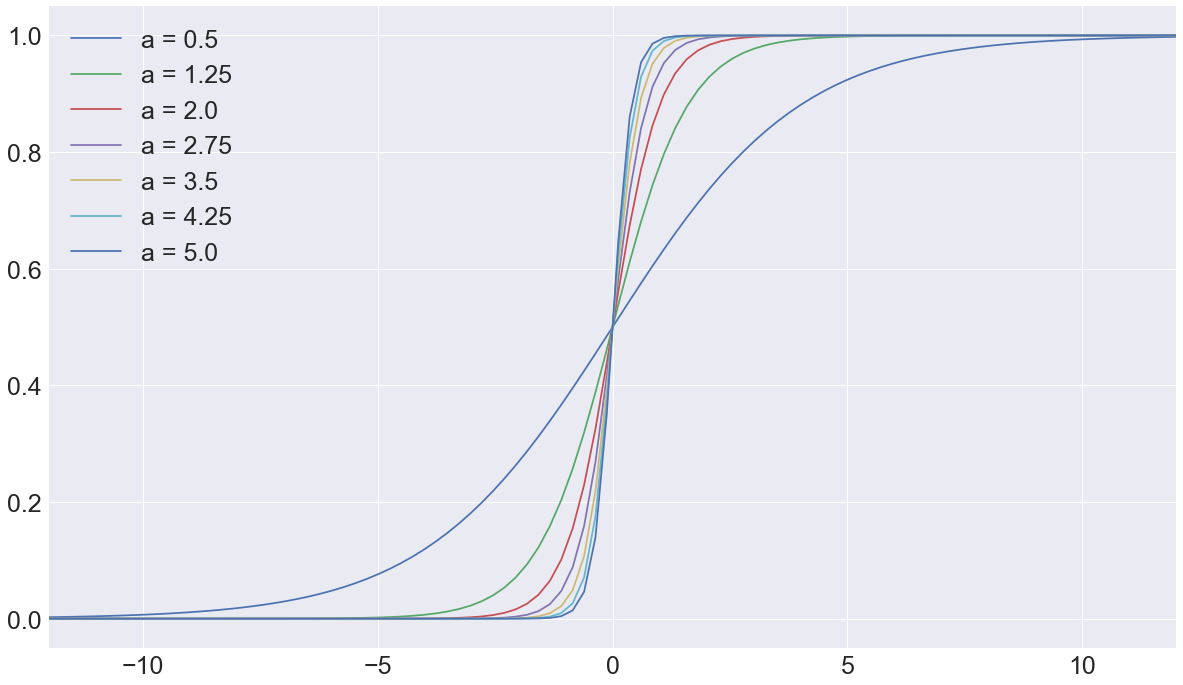

In [58]:
plot_logistic()

### Wieloklasowa regresja logistyczna

* dla problemu $K$-klasowego w regresji logistycznej definiujemy $K-1$ 
$$\begin{align}
\ln\frac{p(y_1\mid x)}{p(y_K\mid x)}&=\ln\frac{p_1(x)}{p_K(x)}=\theta_1x\\
\dots\\
\ln\frac{p(y_{K-1}\mid x)}{p(y_K\mid x)}&=\ln\frac{p_{K-1}(x)}{p_K(x)}=\theta_{K-1}x\\
\end{align}$$
przy czym poszczególne prawdopodobieństwa $p_i(x)$ __sumują się do $1$__
  
  
  * wybór klasy do mianownika jest nieistotny
    * ważne jest, że rozpatrywane klasy stanowią wszystkie możliwości i ich prawdopodobieństwa sumują się do jedności
* biorąc pod uwagę, że $$p_1(x)+\dots+p_K(x)=1$$ można pokazać, że prawdopodobieństwo dla pojedynczej klasy
$$\begin{align}
\text{niech}\;\;\theta_i^Tx=t_i&\\
p_1(x)&=\exp(t_1)\,p_K(x)\\
\dots\\
p_{K-1}(x)&=\exp(t_{K-1})\,p_K(x)\\
\\
\text{dla klasy K mamy}\;\;&\\
p_K(x)&=\exp(t_K)\,p_K(x)\;\Longrightarrow\\
&\Longrightarrow\exp(t_K)=1\;\Longrightarrow\\
&\Longrightarrow\;t_K=\theta_K^Tx=0\;\Longrightarrow\;\theta_K=0\\
\\
\text{prawdopodobieństwa}\;\;&p_1(x)+\dots+p_K(x)=1\;\;\text{sumują się stąd}&\\
p_K(x)&=1-\sum_{j=1}^{K-1}p_j(x)=1-\sum_{j=1}^{K-1}\exp(t_j)\,p_K(x)\\
&=1-p_K(x)\sum_{j=1}^{K-1}\exp(t_j)\tag{*}\\
\\
\text{jednocześnie}\;\;p_i(x)&=\exp(t_i)\,p_K(x)\;\;\Longrightarrow\;\;p_K(x)=\frac{p_i(x)}{\exp(t_i)}\tag{**}\\
\\
p_i(x)&=\exp(t_i)\,p_K(x)\\
&=\exp(t_i)\left[1-p_K(x)\sum_{j=1}^{K-1}\exp(t_j)\right]&&\text{suma z (*)}\\
&=\exp(t_i)\left[1-\frac{p_i(x)}{\exp(t_i)}\sum_{j=1}^{K-1}\exp(t_j)\right]&&\text{(**) na}\;\;p_K(x)\\
&=\exp(t_i)-p_i(x)\sum_{j=1}^{K-1}\exp(t_j)\\
\\
\text{na koniec proste przestawienia}\;\;&\\
p_i(x)\left[1+\sum_{j=1}^{K-1}\exp(t_j)\right]&=\exp(t_i)\\
\\
%p_i(x)&=\frac{\exp(t_i)}{1+\sum_{j=1}^{K-1}\exp(t_j)}
\end{align}$$
$$\boxed{
p_i(x)=\frac{\exp(t_i)}{1+\sum_{j=1}^{K-1}\exp(t_j)}
}$$

* taką postać funkcji nazywamy __softmax__

* bardzo szybka i sprawna metoda

In [59]:
def simple_logistic_regression(n_samples=100, centers=2, odds='odds', penalty='l2'):
    X, y = make_blobs(n_samples=n_samples, centers=centers)
    cls = LogisticRegression(n_jobs=-1, penalty=penalty)
    cls.fit(X, y)
    
    fig_lines = (centers + 2) / 2
    fig, ax = plt.subplots(fig_lines, 2, figsize=(18, fig_lines * 8))

    h=0.025
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax[0, 0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    ax[0, 0].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax[0, 0].set_xlim(xx.min(), xx.max())
    ax[0, 0].set_ylim(yy.min(), yy.max())
    ax[0, 0].set_xticks(())
    ax[0, 0].set_yticks(())
    
    # odds lub log-odds dla poszczegolnych klas
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    for n in range(centers):
        if odds == 'odds':
            Z = cls.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        elif odds == 'log':
            Z = cls.predict_log_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        Z = Z.reshape(xx.shape)
        row = (n + 1) / 2; col = (n + 1) % 2
        ax[row, col].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

        ax[row, col].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', 
                             cmap=plt.cm.Paired)
        ax[row, col].set_xlim(xx.min(), xx.max())
        ax[row, col].set_ylim(yy.min(), yy.max())
        ax[row, col].set_xticks(())
        ax[row, col].set_yticks(())
    
    plt.tight_layout()

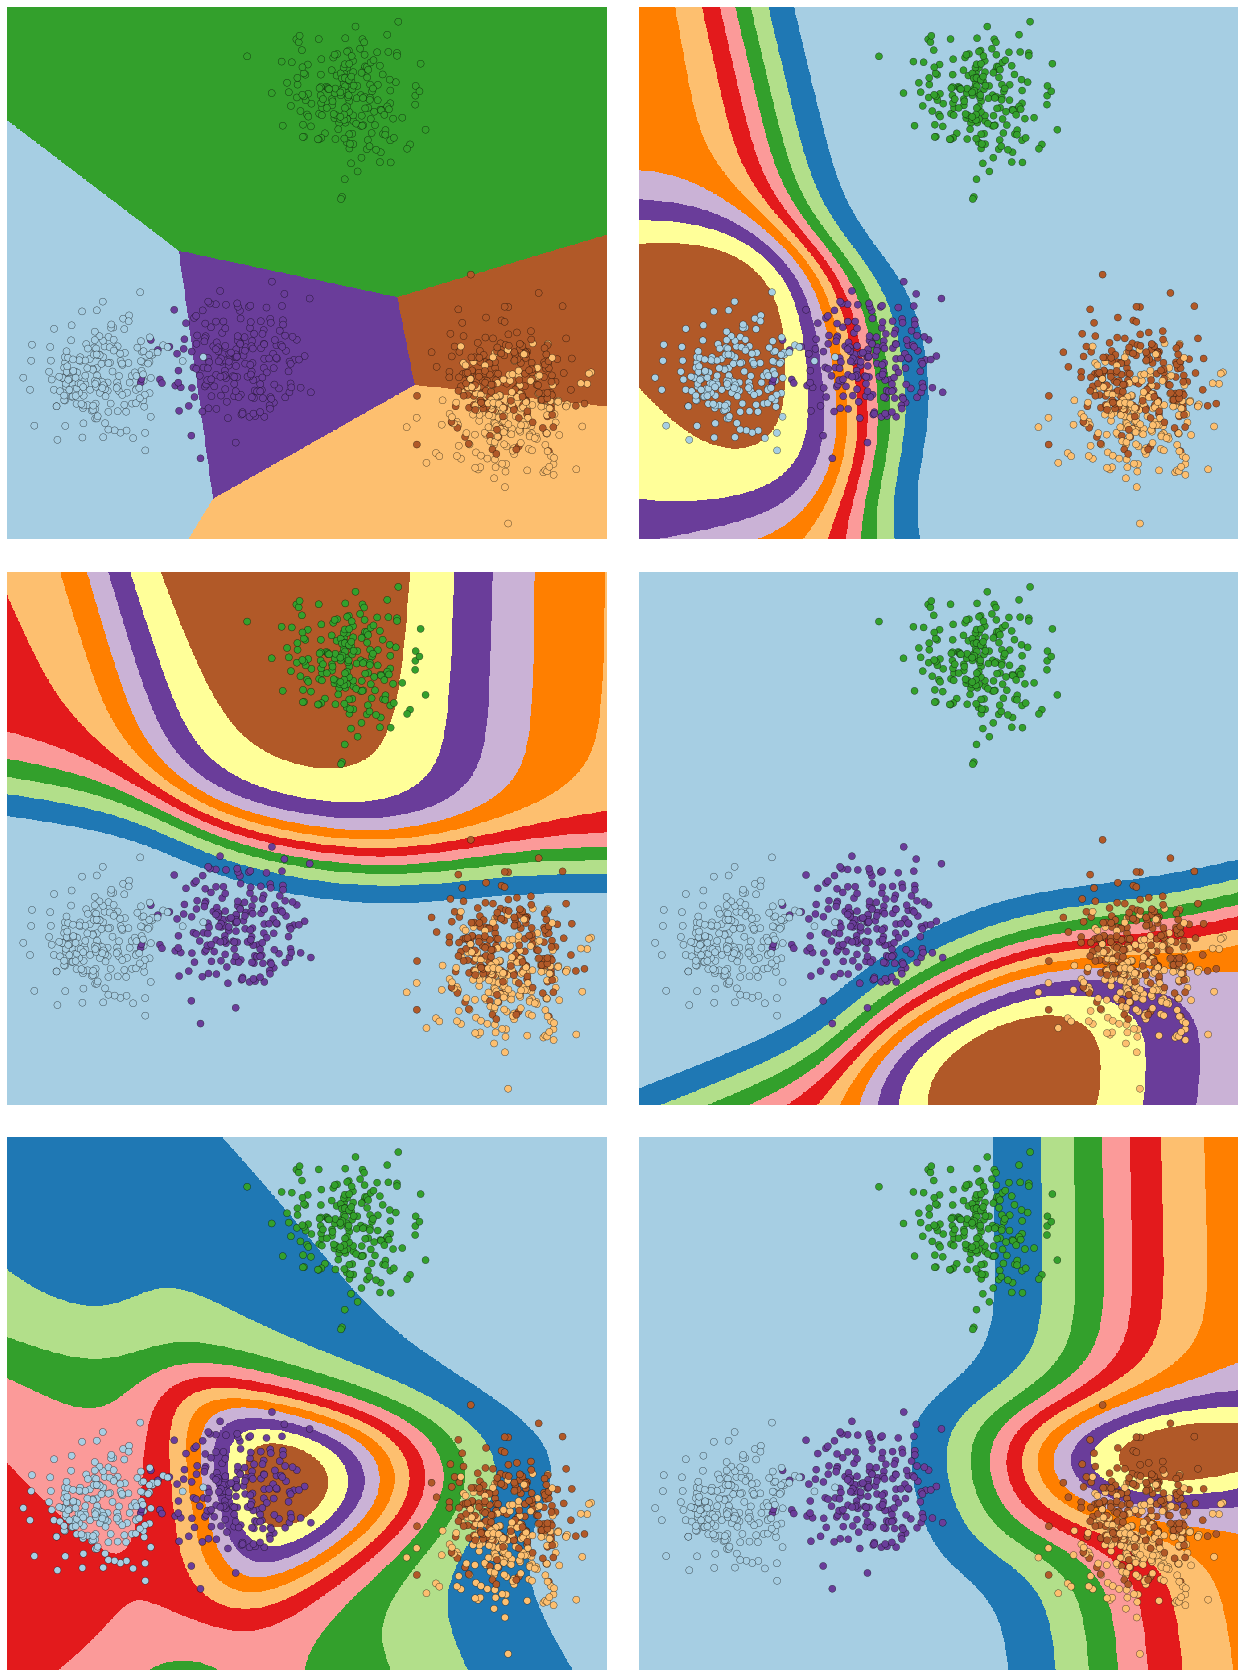

In [60]:
simple_logistic_regression(n_samples=1000, centers=5, odds='odds')

#### Przykład dla danych astronomicznych

In [61]:
def astro_logistic_regression():
    X, y = fetch_rrlyrae_combined()
    take_only = 70000
    X = X[:, [1, 0]]
    #y = y[:take_only]
    skf = StratifiedKFold(n_splits=10)
    skf.get_n_splits(X, y)
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    for train_ind, test_ind in skf.split(X, y):
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        break
    for k, cls in enumerate([LogisticRegression(n_jobs=-1), 
                             LogisticRegressionCV(n_jobs=-1)]):
        cls.fit(X_train, y_train)
        h=0.01
        xlim = (0.7, 1.35)
        ylim = (-0.15, 0.4)
        xx, yy = np.meshgrid(np.arange(xlim[0], xlim[1], h), np.arange(ylim[0], ylim[1], h))
        Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])  #[:, 1]

        Z = Z.reshape(xx.shape)
        ax[k].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
        ax[k].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', 
                      cmap=plt.cm.Paired)
    plt.tight_layout()

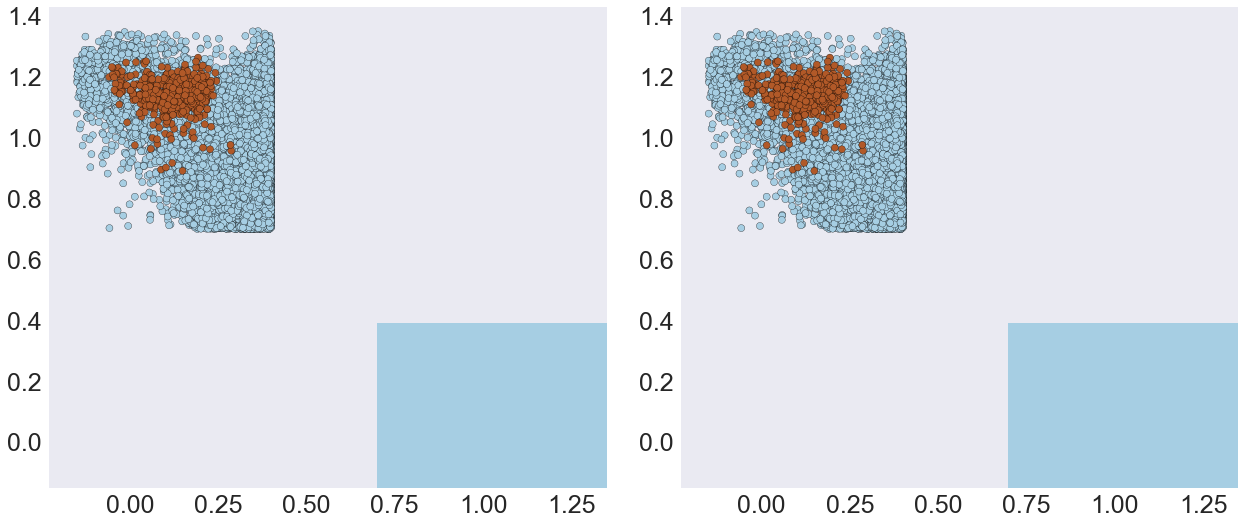

In [62]:
astro_logistic_regression()

## Funkcja likelihood problem binarny

* funkcja likelihood może być, dla problemu _binarnego_, zapisana jako
$$p(y\mid\theta)=p(y=y_1\mid\theta)^{y_1}(1-p(y_1\mid\theta))^{1-y_1}$$
dla całego zbioru danych mamy
$$P(Y\mid\theta)=\prod_{n=1}^N \left(p(\hat{y}(x_n)\mid\theta)\right)^{y_n}\left(1-p(\widehat{y}(x_n)\mid\theta)\right)^{1-y_n}$$
dla $y_i\in\{0, 1\}$
* biorąc logarytm otrzymujemy __log-likelihood__
$$\boxed{
L(\theta)=-\sum_{n=1}^Ny_n\ln\widehat{y}(x_n)+
(1-y_n)\ln(1-\widehat{y}(x_n))\;
}$$
która jest znana jako __funkcja kosztu entropii krzyżowej__


* uczenie może być przeprowadzone iteracyjnie
  * niech $\widehat{y}(x)=\sigma(\theta^Tx)$
  * pochodna funkcji sigmoidalnej 
  $$\frac{d\sigma(t)}{dt}=\sigma(t)(1-\sigma(t))$$
  * gradient funkcji kosztu 
  $$\nabla L(\theta)=\sum_n \left(\sigma(\theta^Tx_n)-y_n\right)x_n=X^T\left(\sigma(\theta^Tx_n)-y_n\right)$$
  * i metoda spadku gradientu
  $$\theta^{(i)}=\theta^{(i-1)}-\mu_i X^T\left(\sigma(\theta^Tx_n)^{(i-1)}-y_n\right)$$
  
  
* uczenie $\theta$ może powodować problemy nawet gdy$\dots$ problem jest _liniowo separowalny_!
  * jest nieskończenie wiele hiperpłaszczyzn $\theta^Tx=0$ rozdzielających klasy
  * konieczna regularyzacja

## Funkcja likelihood problem wieloklasowy

* regresja logistyczna jest zdefiniowana dla każdej klasy z osobna
$$P(y_k\mid x)=\frac{\exp(\theta_k^Tx)}{\sum_{j=1}^K\exp(\theta_j^Tx)}$$
* wtedy _log-odds_ dla danej klasy jest dane przez 
$$\ln\frac{P(y_k\mid x)}{P(y_K\mid x)}=(\theta_k-\theta_K)^Tx=\widehat{\theta}_k^Tx$$
* to daje funkcję _likelihood_ dla problemu wieloklasowego dla $y_{nk}\in\{0,1\}$
$$P(y;\theta_1,\dots,\theta_K)=\prod_{n=1}^N\prod_{k=1}^K(P(y_k\mid x))^{y_{nk}}$$
* oraz odpowiadającą jej _log-likelihood_
$$\boxed{L(\theta_1,\dots,\theta_K)=-\sum_n\sum_ky_{nk}\ln P(y_k\mid x)\;}$$
zwana funkcją __cross-entropy__

# Model Support Vector Machines
* dla problemów liniowo separowalnych istnieje __nieskończenie wiele__ granic decyzyjnych
  * czy istnieje __optymalna__ dla danego problemu?
  
  <img src="../mum_figures/SVM.png" width=100%/> [rysunek za Wikipedią]
  
  ale o tym kiedy indziej$\dots$